# Main Notebook

## Global Variables

In [7]:
%load_ext autoreload
%autoreload 2

from p_pack import globals as g

# The total number of optimization steps to perform during training.
g.num_steps: int = 100

#training rate
g.training_rate : float =  0.1

# The frequency at which data is re-uploaded into the circuit. A new data layer is introduced every `reupload_freq` layers.
g.reupload_freq: int = 3

# The number of modes in the photonic circuit.
g.num_modes_circ: int = 10

# The number of layers in the photonic circuit.
g.depth: int = 10

# The user only needs to modify this FEATURE_SIZE.
g.num_features= 4

# probability of sucess for each mode
g.p_suc_inputs = 1

#intended photon input array - 'full' for all modes, 'n' for n modes, for specify list of positions
g.input_positions= '3'

#Aim for number of photons
g.aim = 3

# 0 to not discard, 1 to discard 
g.discard = 0

# Comparison operator used when deciding whether to discard
# training updates based on the number of photons measured.
# Possible values: '!=', '<', '<=', '>', '>=', '=='
g.discard_condition = '!='

# Optional range for photon counts when using discard_condition='range'.
# Should be a tuple (min_value, max_value). Set to None to disable.
g.discard_range = None

#switch for the trainable small photon loss scale, 0 - for no scaling, 1 - for scaling
g.loss_function = 0

# Batch processing configuration
# 'full'  : use entire dataset each update
# 'mini'  : use mini-batches of size ``mini_batch_size``
# 'single': process one sample at a time
g.batch_mode: str = 'single'
g.mini_batch_size: int = 300


g.input_config = g.input_config_maker(g.input_positions, g.num_modes_circ, g.p_suc_inputs)
print(g.input_config)

from p_pack import pre_p, circ, model, loss, optimiser, train

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
(Array([1, 0, 0, 0, 0, 1, 0, 0, 0, 1], dtype=uint8), Array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32))


## Load Data

In [2]:
split_data = g.load_and_split_data(g.num_features)
train_set, train_labels, test_set, test_labels = split_data

# Rescale training + test features to range [-pi/2, pi/2]
train_set = pre_p.rescale_data(train_set, min_val = -(g.np.pi)/2, max_val = (g.np.pi/2))
test_set = pre_p.rescale_data(test_set, min_val = -(g.np.pi)/2, max_val = (g.np.pi/2))

## Training Loss - Single Depth

Training with, num_features:  4 , num_steps:  1000 , took  0.3742466330528259  minutes


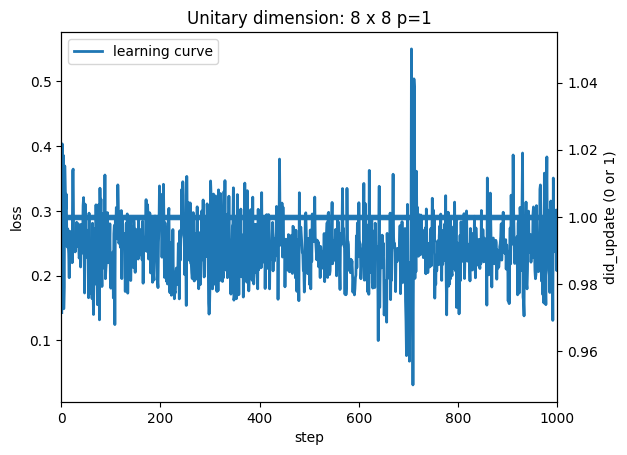

In [6]:
# Initialize the phases
init_phases = circ.initialize_phases(g.depth, 2*g.num_features, )  
weights_data = g.jnp.ones(shape = [init_phases.shape[0],init_phases.shape[1]])
# Initialize the carry for Adam.
master_key = g.jax.random.PRNGKey(2)
# init = (init_phases, train_set, train_labels, weights_data, 0.0*init_phases, 0.0*init_phases, 0.0*weights_data, 0.0*weights_data, master_key)
photon_loss_scale = float(1)

# compute the very first loss:
initial_loss, (n0, key) = loss.loss(init_phases, train_set, train_labels, weights_data, photon_loss_scale, g.input_config, master_key)


init_carry = (init_phases, train_set, train_labels, weights_data, photon_loss_scale,
              0.0*init_phases, 0.0*init_phases,
              0.0*weights_data, 0.0*weights_data,
              0.0*photon_loss_scale, 0.0*photon_loss_scale, 
              key, initial_loss)
   


# Run the training, and output  time taken. 
b = g.time.time()
carry, loss_mem, update_mem = g.jax.block_until_ready(train.train(init_carry))
e = g.time.time()
print('Training with, num_features: ', g.num_features, 
      ', num_steps: ', g.num_steps,
        ', took ', (e-b)/60, ' minutes')

# Loss Before/After on train set + Loss on test set
trained_phases, trained_weights = carry[0], carry[3]
steps  = g.np.array(loss_mem[:, 0], dtype=int)
losses = g.np.array(loss_mem[:, 1], dtype=float)
updates = g.np.array(update_mem, dtype=int)
# init_loss = loss.loss(init_phases, train_set, train_labels, weights_data, g.input_config, master_key)
# train_loss = loss.loss(trained_phases, train_set, train_labels, trained_weights, g.input_config, master_key)
# test_loss = loss.loss(trained_phases, test_set, test_labels, trained_weights)

# plotting the learning curve
fig, ax1 = g.plt.subplots()
ax1.plot(g.np.array(loss_mem[:,0]), g.np.array(loss_mem[:,1]), linewidth=2, label=r"learning curve" )
ax1.set(xlim = (0,g.num_steps), xlabel="step", ylabel = "loss",)
ax2 = ax1.twinx()
ax2.plot(steps, updates, 'o', alpha=0.3, markersize=3, label="did_update")
ax2.set_ylabel("did_update (0 or 1)")
# ax.axhline(init_loss, color='r', linestyle='--', label=f"Init train loss = {init_loss:.4f}")
# ax.axhline(train_loss, color='g', linestyle='--', label=f"Final train loss = {train_loss:.4f}")
# ax.axhline(test_loss, color='b', linestyle='--', label=f"Test loss = {test_loss:.4f}")
unitary_shape = trained_phases.shape  
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc="upper right")
ax1.set_title(f"Unitary dimension: {2*unitary_shape[1]} x {2*unitary_shape[1]} p={g.p_suc_inputs}")
ax1.legend()
g.plt.show()

## Training Loss - Multi Depth

In [14]:
depth_list = [8, 10, 12] # depth = number of layers

Training with depth = 8


ValueError: not enough values to unpack (expected 10, got 8)

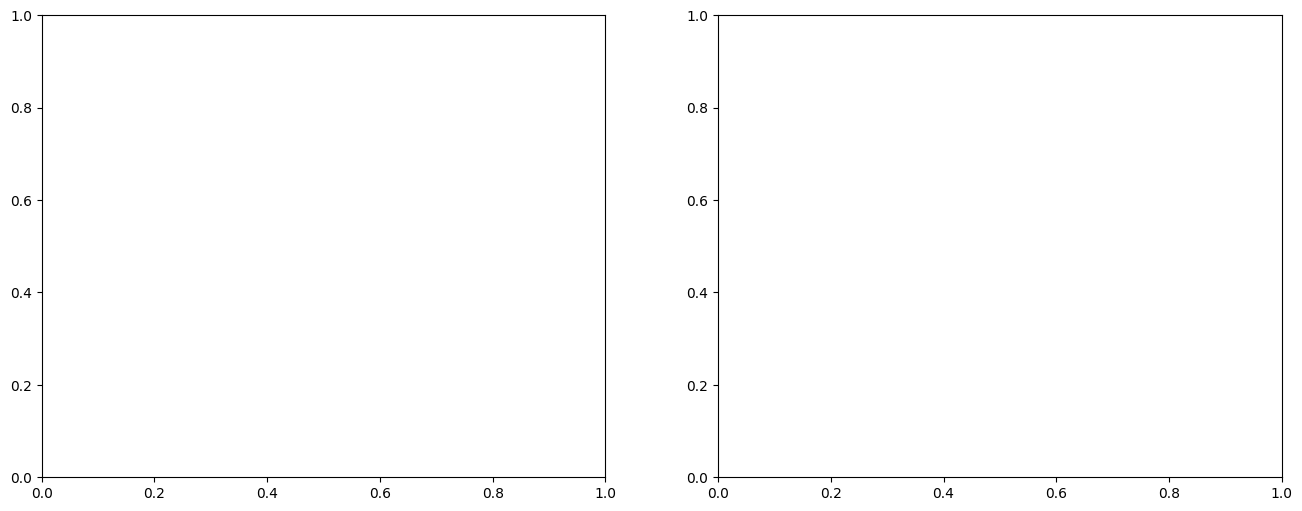

In [15]:
results = []; fig, (ax1, ax2) = g.plt.subplots(1, 2, figsize=(16, 6))
for depth in depth_list:
    print(f"Training with depth = {depth}"); 
    #initialize parameters
    a = g.time.time()
    init_phases = circ.initialize_phases(depth, 2*g.num_features)
    weights_data = g.jnp.ones(shape=[init_phases.shape[0], init_phases.shape[1]])
    init = ( init_phases, train_set, train_labels, weights_data,0.0*init_phases, 0.0*init_phases, 0.0*weights_data, 0.0*weights_data)
    # Run the training.
    b = g.time.time()
    carry, loss_mem = g.jax.block_until_ready(train.train)(init)
    # Loss Before/After on train set + Loss on test set
    c = g.time.time()
    trained_phases, trained_weights = carry[0], carry[3]
    init_loss, train_loss, test_loss = float(loss.loss(init_phases, train_set, train_labels, weights_data)), float(loss.loss(trained_phases, train_set, train_labels, trained_weights)), float(loss.loss(trained_phases, test_set, test_labels, trained_weights))
    d = g.time.time()
    #plot learning curve for given depth
    ax1.plot(g.np.array(loss_mem[:,0]), g.np.array(loss_mem[:,1]), label=f"Depth {depth}")
    #timing calcs
    init_time_min, train_time_min, loss_time_min, total_time_min = (b-a)/60, (c-b)/60, (d-c)/60, (d-a)/60
    #append results
    results.append({"depth": depth, "train_loss_before": init_loss, "train_loss_after": train_loss, "test_loss_after": test_loss, 
                    "init_time_min": init_time_min, "loss_time_min": loss_time_min, "train_time_min": train_time_min,"total_time_min": total_time_min})
# Finalize left subplot
ax1.set_xlim(0, g.num_steps)
ax1.set_xlabel("step"); ax1.set_ylabel("loss")
ax1.set_title(f"Learning Curves (Unitary dim: {2*init_phases.shape[1]}×{2*init_phases.shape[1]})")
ax1.legend()
# Prepare data for right subplot (final losses vs depth)
depth_vals, train_vals, test_vals = [r["depth"] for r in results], [r["train_loss_after"] for r in results], [r["test_loss_after"] for r in results]
# Plot final losses vs depth
ax2.plot(depth_vals, train_vals, 'o-', label="Train loss"); ax2.plot(depth_vals, test_vals,  's-', label="Test loss")
ax2.set_xlabel("Depth"); ax2.set_ylabel("Final loss")
ax2.set_title(f"Final Loss vs Depth (Unitary dim: {2*init_phases.shape[1]}×{2*init_phases.shape[1]})")
ax2.grid(True)
ax2.legend()
g.plt.tight_layout()
g.plt.show()
# Create and print the results table
results_df = g.pd.DataFrame(results)
print(results_df.to_string(index=False, float_format="%.4F"))

## Training Loss - Multi Feature

In [90]:
feature_dims = [3,4,5]
depth = 10  # Set your desired constant depth here

Training with 3 features (depth=10)
Training with 4 features (depth=10)
Training with 5 features (depth=10)


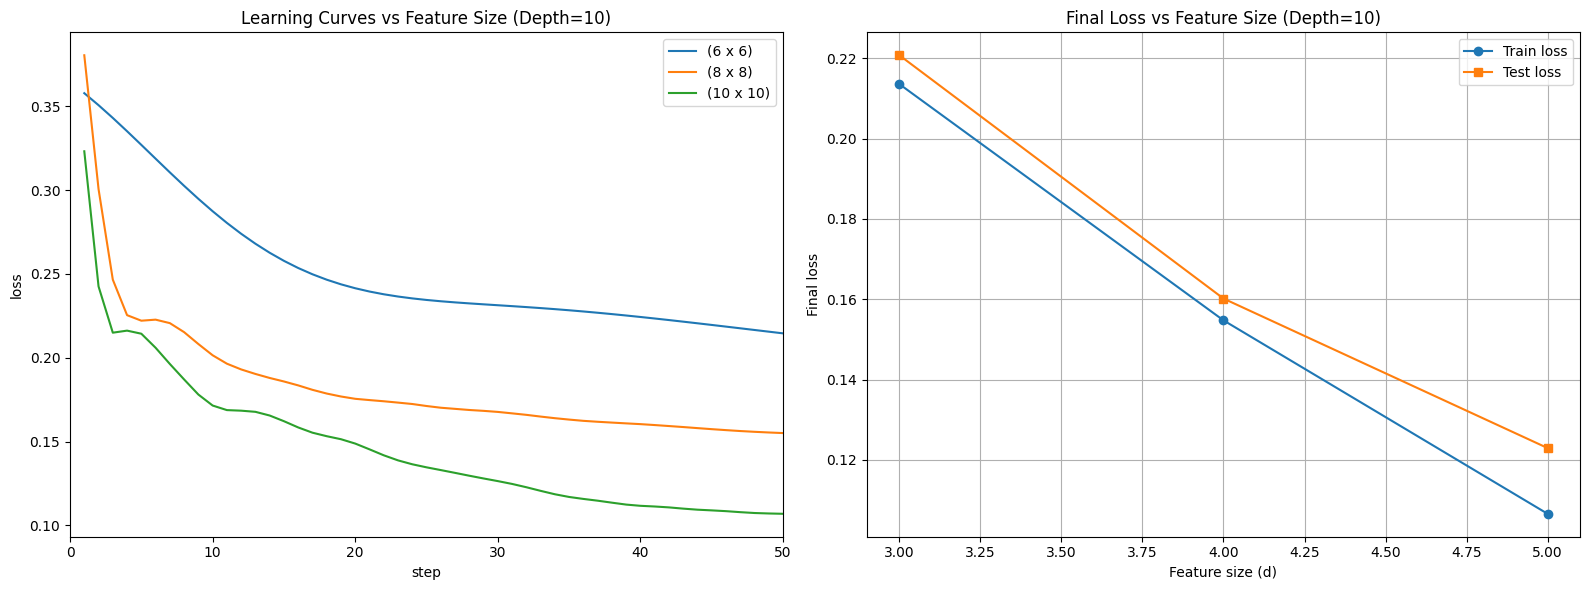

 features  train_loss_before  train_loss_after  test_loss_after  load_data_time_min  init_time_min  loss_time_min  train_time_min  total_time_min
        3             0.3579            0.2136           0.2207              0.0016         0.0004         0.3992          0.0006          0.4018
        4             0.3805            0.1547           0.1602              0.0013         0.0007         0.6971          0.0008          0.7000
        5             0.3232            0.1066           0.1230              0.0014         0.0004         1.2625          0.0008          1.2652


In [91]:
results = []
fig, (ax1, ax2) = g.plt.subplots(1, 2, figsize=(16, 6))
for f_dims in feature_dims:
    print(f"Training with {f_dims} features (depth={depth})")
    # making sure to change num_features in globals file as all other files refernce from there
    g.num_features = f_dims
    # Load, split and rescale data for the current feature dimension
    a = g.time.time()
    split_data = globals.load_and_split_data(f_dims)
    train_set, train_labels, test_set, test_labels = split_data
    train_set = pre_p.rescale_data(train_set, min_val = -(g.np.pi)/2, max_val = (g.np.pi/2))
    test_set = pre_p.rescale_data(test_set, min_val = -(g.np.pi)/2, max_val = (g.np.pi/2))
    # Initialize the phases and weights
    b = g.time.time()
    init_phases = circ.initialize_phases(depth, 2*f_dims)
    weights_data = g.jnp.ones(shape=[init_phases.shape[0], init_phases.shape[1]])
    init = (init_phases, train_set, train_labels, weights_data, 0.0*init_phases, 0.0*init_phases, 0.0*weights_data, 0.0*weights_data)
    # training
    c = g.time.time()
    carry, loss_mem = g.jax.block_until_ready(train.train)(init)
    # Loss Before/After on train set + Loss on test set
    d = g.time.time()
    trained_phases, trained_weights  = carry[0], carry[3]
    init_loss, train_loss, test_loss = float(loss.loss(init_phases, train_set, train_labels, weights_data)), float(loss.loss(trained_phases, train_set, train_labels, trained_weights)), float(loss.loss(trained_phases, test_set, test_labels, trained_weights))
    # time calcs
    e = g.time.time()
    load_data_time_min, init_time_min, train_time_min, loss_time_min, total_time_min = (b-a)/60, (c-b)/60, (d-c)/60, (e-d)/60, (e-a)/60
    #plot data
    ax1.plot(g.np.array(loss_mem[:,0]), g.np.array(loss_mem[:,1]), label=f"({2*f_dims} x {2*f_dims})")
    #store results
    results.append({"features": f_dims, "train_loss_before": init_loss, "train_loss_after": train_loss, "test_loss_after": test_loss, 
                    "load_data_time_min": load_data_time_min, "init_time_min": init_time_min, "loss_time_min": loss_time_min, "train_time_min": train_time_min,"total_time_min": total_time_min})
# finalize left subplot
ax1.set_xlim(0, g.num_steps); ax1.set_xlabel("step"); ax1.set_ylabel("loss")
ax1.set_title(f"Learning Curves vs Feature Size (Depth={depth})"); ax1.legend()
# prepare and plot final losses vs feature size
f_vals = [r["features"] for r in results]; tr = [r["train_loss_after"] for r in results]; te = [r["test_loss_after"] for r in results]
ax2.plot(f_vals, tr, 'o-', label="Train loss"); ax2.plot(f_vals, te, 's-', label="Test loss")
ax2.set_xlabel("Feature size (d)"); ax2.set_ylabel("Final loss")
ax2.set_title(f"Final Loss vs Feature Size (Depth={depth})"); ax2.grid(True); ax2.legend()
g.plt.tight_layout(); g.plt.show()
# print results table
results_df = g.pd.DataFrame(results); print(results_df.to_string(index=False, float_format="%.4F"))